In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import skew, kurtosis
def generate_synthetic_data(n=2000, seed=42):
    """
    Generate a synthetic dataset with demographics, income, transactions, and spend.
    
    Parameters
    ----------
    n : int
        Number of rows to generate
    seed : int
        Random seed for reproducibility
    
    Returns
    -------
    pd.DataFrame
    """
    np.random.seed(seed)
    
    df = pd.DataFrame({
        'date': pd.date_range('2020-01-01', periods=n, freq='D'),
        'region': np.random.choice(['North','South','East','West','Central'], size=n),
        'age': np.random.normal(42, 10, size=n).clip(18, 75).round(1),
        'income': np.random.lognormal(mean=10.7, sigma=0.35, size=n).round(2),
        'transactions': np.random.poisson(lam=4, size=n),
    })
    
    
    base = df['income'] * 0.0013 + df['transactions']*20 + np.random.normal(0, 60, size=n)
    df['spend'] = np.maximum(0, base).round(2)
    
    # inject missing values randomly
    df.loc[np.random.choice(df.index, int(0.02*n), replace=False), 'income'] = np.nan
    df.loc[np.random.choice(df.index, int(0.015*n), replace=False), 'spend'] = np.nan
    df.loc[np.random.choice(df.index, int(0.01*n), replace=False), 'age'] = np.nan
    
    # inject outliers
    df.loc[np.random.choice(df.index, int(0.005*n), replace=False), 'transactions'] = df['transactions'].max() + np.random.randint(10, 20)
    df.loc[np.random.choice(df.index, int(0.005*n), replace=False), 'income'] *= 10
    df.loc[np.random.choice(df.index, int(0.005*n), replace=False), 'spend'] *= 8
    
    return df

# Example usage
df_big = generate_synthetic_data(n=5000, seed=123)
print(df_big.shape)
df_big.head()
df = df_big


(5000, 6)


### Description
We start by inspecting the structure of the dataset, checking data types, missing values, and statistical summaries.

In [2]:
df.info(), df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          5000 non-null   datetime64[ns]
 1   region        5000 non-null   object        
 2   age           4950 non-null   float64       
 3   income        4900 non-null   float64       
 4   transactions  5000 non-null   int64         
 5   spend         4925 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 234.5+ KB


(None,
 date              0
 region            0
 age              50
 income          100
 transactions      0
 spend            75
 dtype: int64)

Numerical Column Profile

In [3]:
desc = df[['age','income','transactions','spend']].describe().T
desc['skew'] = [skew(df[c].dropna()) for c in desc.index]
desc['kurtosis'] = [kurtosis(df[c].dropna()) for c in desc.index]
desc

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
age,4950.0,42.182364,10.003273,18.00,35.100,42.200,48.8000,75.0,0.121009,-0.157538
income,4900.0,49918.343427,38398.510328,12143.33,35492.095,44796.535,57146.4375,1114412.3,12.717438,233.696089
transactions,5000.0,4.153400,2.473033,0.00,3.000,4.000,5.0000,25.0,3.163425,23.553398
spend,4925.0,149.282264,110.316061,0.00,94.690,141.910,193.3300,2605.2,9.059314,157.106554


### Findings: Univariate Distributions

We visualize key numeric variables (`income`, `age`, `transactions`, `spend`) using histograms and boxplots.
- **Income**: Right-skewed (positively skewed), due to the lognormal distribution with long right tail.  
- **Age**: Roughly normal, truncated at the bounds (22–70).  
- **Transactions**: Count-based (Poisson), skewed toward lower counts with a few extreme values.  
- **Spend**: Right-skewed with some outliers, reflecting shocks or unusually high spending.

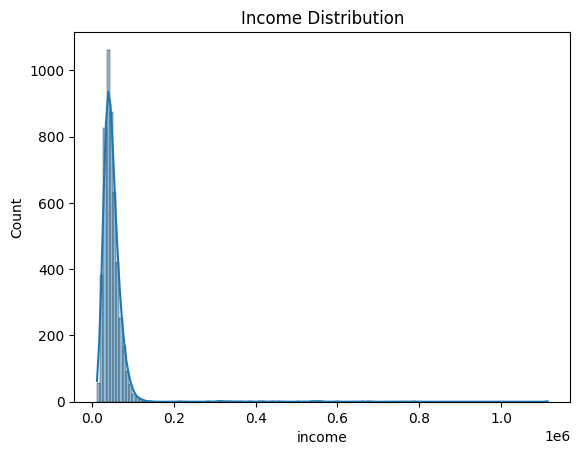

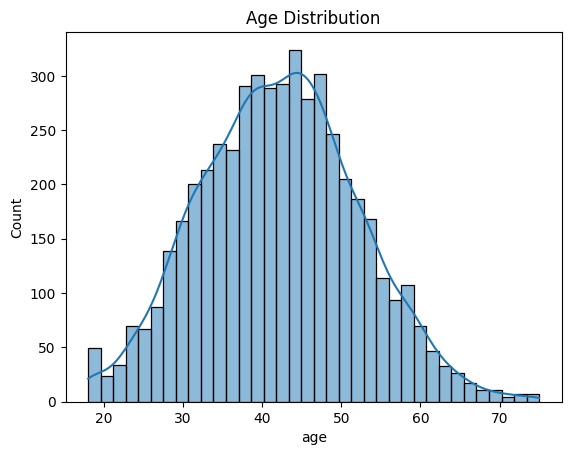

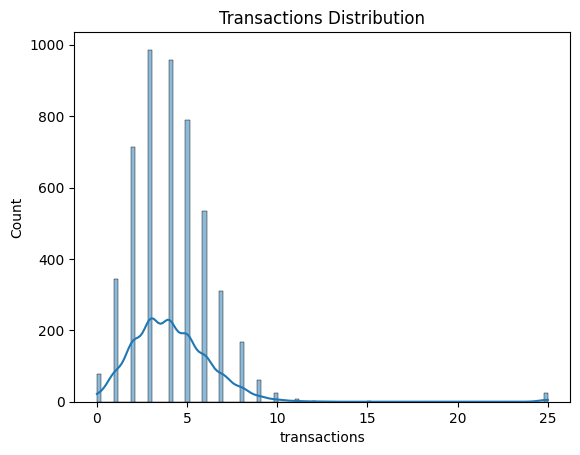

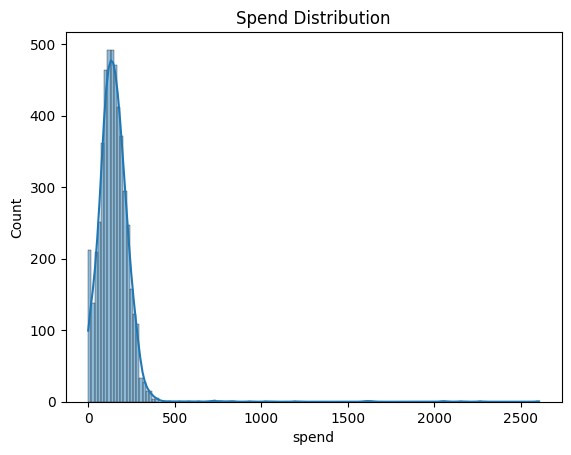

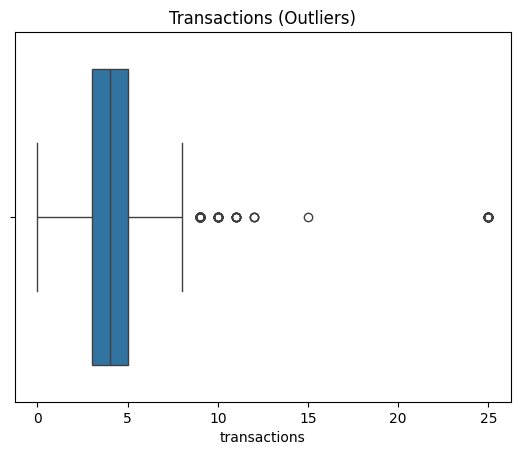

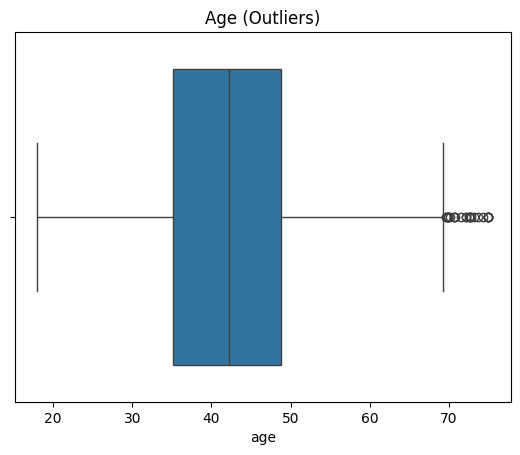

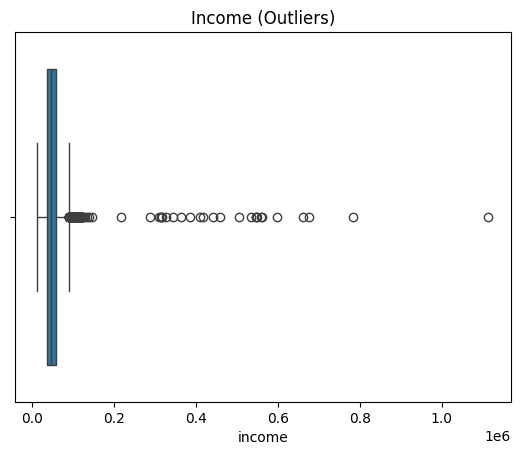

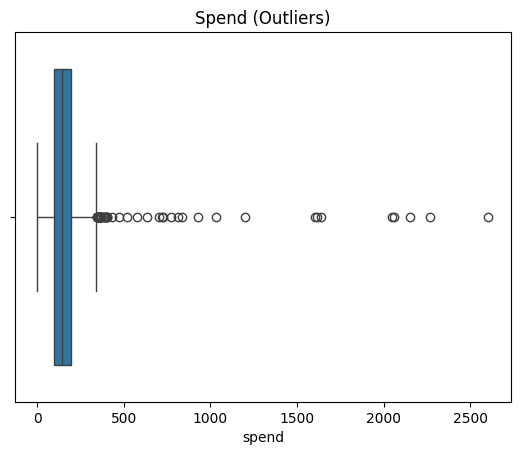

In [4]:

sns.histplot(df['income'], kde=True)
plt.title('Income Distribution')
plt.show()

sns.histplot(df['age'], kde=True)
plt.title('Age Distribution')
plt.show()

sns.histplot(df['transactions'], kde=True)
plt.title('Transactions Distribution')
plt.show()

sns.histplot(df['spend'], kde=True)
plt.title('Spend Distribution')
plt.show()


sns.boxplot(x=df['transactions'])
plt.title('Transactions (Outliers)')
plt.show()

sns.boxplot(x=df['age'])
plt.title('Age (Outliers)')
plt.show()

sns.boxplot(x=df['income'])
plt.title('Income (Outliers)')
plt.show()

sns.boxplot(x=df['spend'])
plt.title('Spend (Outliers)')
plt.show()

### Seasonality Check
We observe some fluctuations in daily spend, but no strong repeating seasonal pattern (dataset is only ~6 months long).  
This suggests no clear seasonality, but time still adds useful structure (e.g., possible trend or shocks).

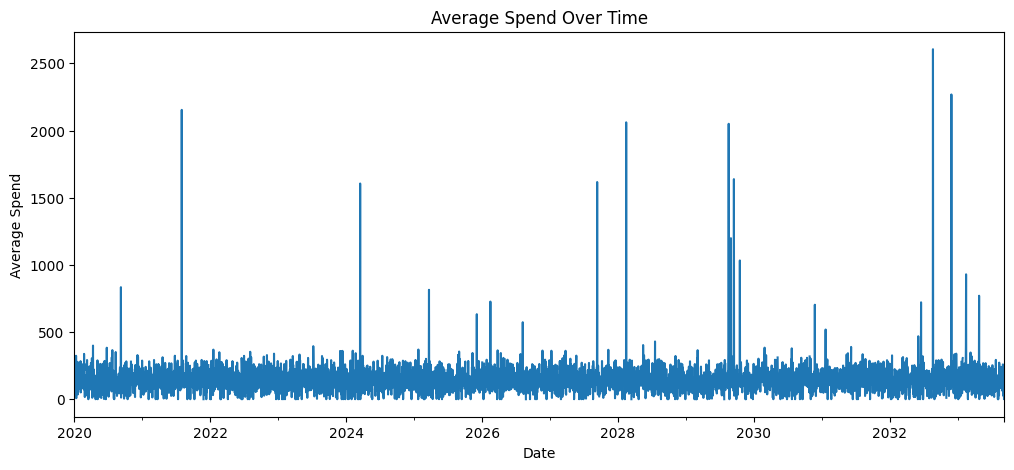

In [5]:
plt.figure(figsize=(12,5))
df.groupby('date')['spend'].mean().plot(kind='line')
plt.title('Average Spend Over Time')
plt.ylabel('Average Spend')
plt.xlabel('Date')
plt.show()

### Findings: Bivariate Relationships

We explore scatterplots and line plots to understand relationships:
- **Income vs Spend**: Higher income generally corresponds to higher spend, but with diminishing returns.  
- **Age vs Spend**: No strong linear relationship, but some middle-aged groups cluster higher spend.  
- **Transactions vs Spend**: Stronger positive relationship, more transactions clearly drive higher spend.

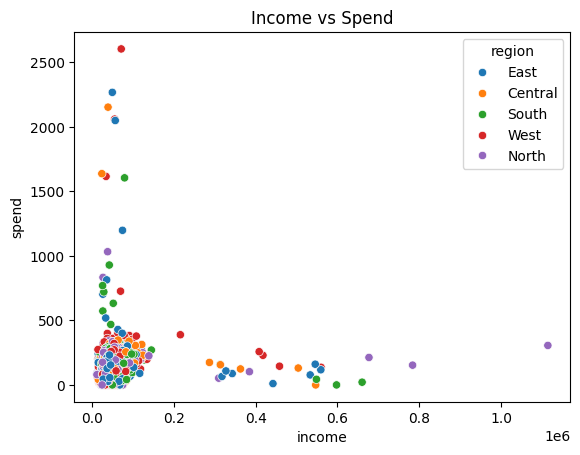

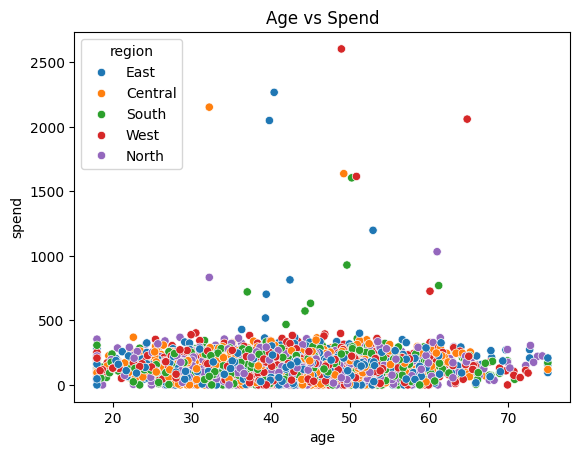

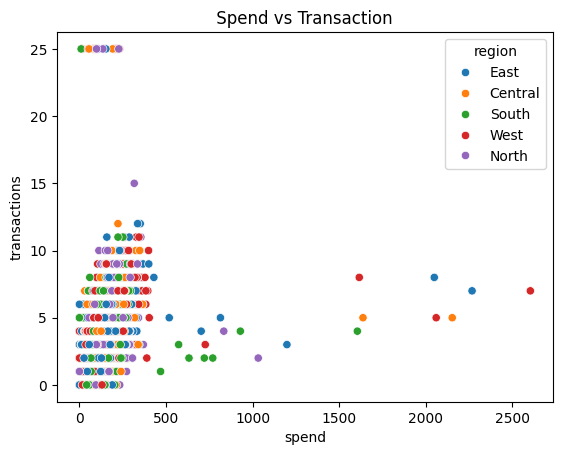

In [6]:
sns.scatterplot(data=df, x='income', y='spend', hue='region')
plt.title('Income vs Spend')
plt.show()

sns.scatterplot(data=df, x='age', y='spend', hue='region')
plt.title('Age vs Spend')
plt.show()

sns.scatterplot(data=df, y='transactions', x='spend', hue='region')
plt.title(' Spend vs Transaction ')
plt.show()

### Correlation Matrix
The correlation heatmap shows the strength of linear associations among numeric variables.  
`Transactions` and `spend` are strongly correlated, while `income` has a weaker but positive correlation with `spend`.

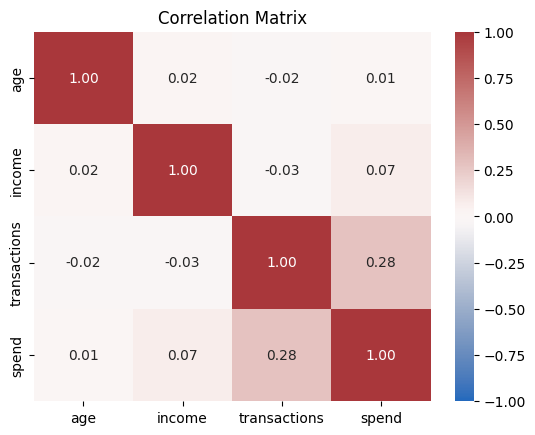

,age,income,transactions,spend
age,1.000000,0.018966,-0.022971,0.011214
income,0.018966,1.000000,-0.026437,0.074235
transactions,-0.022971,-0.026437,1.000000,0.281777
spend,0.011214,0.074235,0.281777,1.000000


In [7]:
corr = df[['age','income','transactions','spend']].corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()
corr

### Insights and Next Steps

### Top 3 Insights
1. **Income is right-skewed**, requiring potential log transformation for modeling.  
2. **Transactions drive spend more directly than income**, suggesting transactions is a strong predictor.  
3. **Outliers in spend and transactions** distort variability and regression fits; handling is required.  

### Assumptions & Risks
- We assume missing values are random and can be imputed safely.  
- If outliers represent true shocks (not errors), removing them risks underestimating volatility.  
- Limited time span restricts seasonal insights, so longer data would be needed for robust trend analysis.  

### Implications for Next Step
- Apply transformations (e.g., log income) to reduce skew.  
- Engineer features from transactions and possibly interactions (income × transactions).  
- Handle missingness and outliers before modeling.